In [69]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
%matplotlib inline  

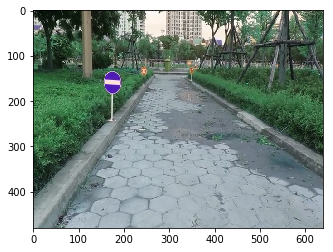

In [84]:
cap = cv2.VideoCapture('./source/Videos/MVI_1049.avi')
count = 0
while count < 102:
    ret, frame = cap.read()
    count += 1
plt.imshow(frame)

In [86]:
print(mask)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [107]:
mask_extend = mask.copy()
remains = np.array(np.where(mask >0))
print(test.shape)
for i in range(test.shape[1]):
    for i in [-1,0, 1]:
        for j in [-1,0,1]:
            mask_extend[remains[0][i]+i, remains[1][i]+j] += 1

(2, 7153)


In [115]:
frame_1 = frame.copy()
hsv = cv2.cvtColor(frame_1, cv2.COLOR_BGR2GRAY)

In [116]:
hsv.shape

(480, 640)

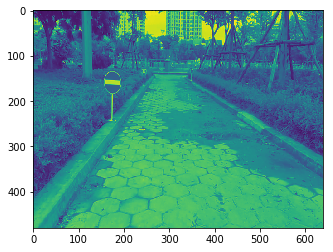

In [117]:
plt.imshow(hsv)

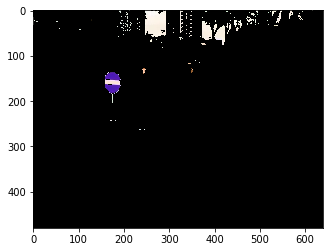

In [88]:
frame_1 = frame.copy()
hsv = cv2.cvtColor(frame_1, cv2.COLOR_BGR2HSV)
# define range of blue color in HSV
lower_blue = np.array([100,150,0])
upper_blue = np.array([215,255,255])
# Threshold the HSV image to get only blue colors
mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

lower_white = np.array([0,0,225], dtype=np.uint8)
upper_white = np.array([255,127,255], dtype=np.uint8)
# Threshold the HSV image to get only blue colors
mask_white = cv2.inRange(hsv, lower_white, upper_white)

mask = cv2.bitwise_or(mask_blue, mask_white)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(frame_1,frame_1, mask= mask)
plt.imshow(res)

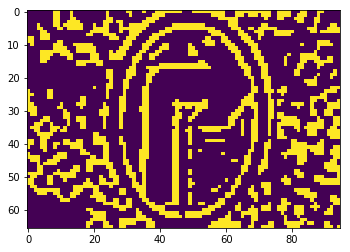

In [50]:
img = cv2.imread('test.png')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(gray, 50, 200)
ret,th = cv2.threshold(edged,127,255, 0)
img_2 = img.copy()
#--- Find all the contours in the binary image ---
_, contours,hierarchy = cv2.findContours(th,2,1)
cnt = contours
big_contour = []
max = 0
for i in cnt:
    area = cv2.contourArea(i) #--- find the contour having biggest area ---
    if(area > max):
        max = area
        big_contour = i 
final = cv2.drawContours(img_2, big_contour, -1, (0,255,0), 3)
plt.imshow(preprocess_image(img))

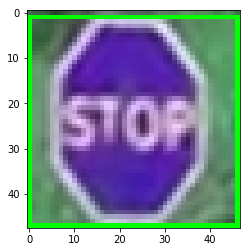

In [32]:
lst = np.reshape(big_contour, [-1,2])
right, bottom = np.amax(lst, axis=0)
left, top = np.amin(lst, axis=0)
frame = cv2.rectangle(img.copy(),(left,top),(right,bottom),(0, 255, 0), 1)
plt.imshow(frame)

In [305]:
print(cap.get(cv2.CAP_PROP_FPS))

59.94005994005994


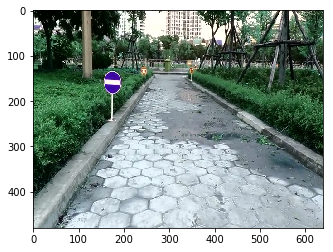

In [64]:
frame_1 =  constrastLimit(frame)
plt.imshow(frame_1)

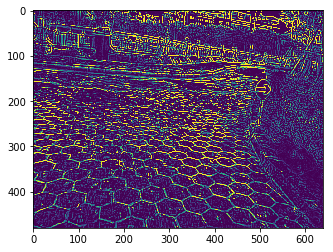

In [292]:
frame_2 = LaplacianOfGaussian(frame_1)
plt.imshow(frame_2)

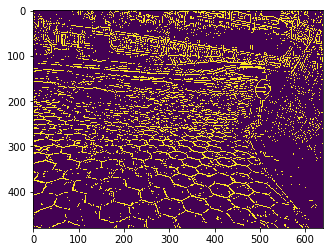

In [293]:
frame_3 = binarization(frame_2)
plt.imshow(frame_3)

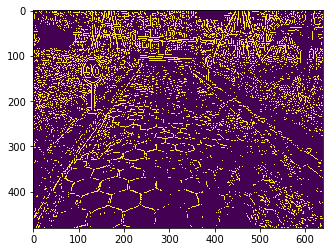

In [280]:
frame_3 = binarization(frame_2)
plt.imshow(frame_3)

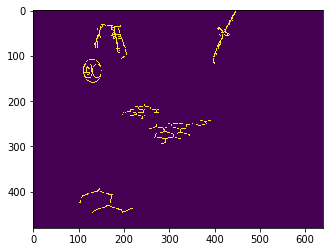

In [303]:
p_img = preprocess_image(frame_1)
p_img = removeSmallComponents(p_img,300)
plt.imshow(p_img)

In [58]:
### Preprocess image
def constrastLimit(image):
	img_hist_equalized = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
	channels = cv2.split(img_hist_equalized)
	channels[0] = cv2.equalizeHist(channels[0])
	img_hist_equalized = cv2.merge(channels)
	img_hist_equalized = cv2.cvtColor(img_hist_equalized, cv2.COLOR_YCrCb2BGR)
	return img_hist_equalized

def LaplacianOfGaussian(image):
	LoG_image = cv2.GaussianBlur(image, (3,3), 0)           # paramter 
	gray = cv2.cvtColor( LoG_image, cv2.COLOR_BGR2GRAY)
	LoG_image = cv2.Laplacian( gray, cv2.CV_8U,3,3,2)       # parameter
	LoG_image = cv2.convertScaleAbs(LoG_image)
	return LoG_image
	
def binarization(image):
	thresh = cv2.threshold(image,96,255,cv2.THRESH_BINARY)[1]
    #thresh = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
	return thresh

def preprocess_image(image):
	image = constrastLimit(image)
	image = LaplacianOfGaussian(image)
	image = binarization(image)
	return image

# Find Signs
def removeSmallComponents(image, threshold):
	#find all your connected components (white blobs in your image)
	nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
	sizes = stats[1:, -1]; nb_components = nb_components - 1

	img2 = np.zeros((output.shape),dtype = np.uint8)
	#for every component in the image, you keep it only if it's above threshold
	for i in range(0, nb_components):
	    if sizes[i] >= threshold:
	        img2[output == i + 1] = 255
	return img2

def findContour(image):
	#find contours in the thresholded image
	cnts = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE	)
	cnts = cnts[0] if imutils.is_cv2() else cnts[1]
	return cnts

def contourIsSign(perimeter, centroid, threshold):
	#  perimeter, centroid, threshold
	# # Compute signature of contour
	result=[]
	for p in perimeter:
		p = p[0]
		distance = sqrt((p[0] - centroid[0])**2 + (p[1] - centroid[1])**2)
		result.append(distance)
	max_value = max(result)
	signature = [float(dist) / max_value for dist in result ]
	# Check signature of contour.
	temp = sum((1 - s) for s in signature)
	temp = temp / len(signature)
	if temp < threshold: # is  the sign
		return True, max_value + 2
	else: 				# is not the sign
		return False, max_value + 2

#crop sign 
def cropContour(image, center, max_distance):
	width = image.shape[1]
	height = image.shape[0]
	top = max([int(center[0] - max_distance), 0])
	bottom = min([int(center[0] + max_distance + 1), width-1])
	left = max([int(center[1] - max_distance), 0])
	right = min([int(center[1] + max_distance+1), height-1])
	return image[left:right, top:bottom]

def findSigns(image, contours, threshold):
	signs = []
	coordinates = []
	for c in contours:
		# compute the center of the contour
		M = cv2.moments(c)
		if M["m00"] == 0:
			continue
		cX = int(M["m10"] / M["m00"])
		cY = int(M["m01"] / M["m00"])
		is_sign, max_distance = contourIsSign(c, [cX, cY], 1-threshold)
		if is_sign:
			sign = cropContour(image, [cX, cY], max_distance)
			signs.append(sign)
			coordinates.append([[cX, cY], max_distance])
        
	return signs, coordinates

def localization(image, min_size_components, similitary_contour_with_circle):
	binary_image = preprocess_image(image)
	#cv2.imwrite('A.png', binary_image)
	binary_image = removeSmallComponents(binary_image, min_size_components)
	#cv2.imwrite('B.png', binary_image)
	cv2.imshow('BINARY IMAGE', binary_image)
	contours = findContour(binary_image)
	signs, coordinates = findSigns(image, contours, similitary_contour_with_circle)

	for obj in coordinates:
		center, max_distance = obj
		width = image.shape[1]
		height = image.shape[0]
		top = max([int(center[0] - max_distance), 0]) - 1
		bottom = min([int(center[0] + max_distance + 1), width-1]) + 1
		left = max([int(center[1] - max_distance), 0])
		right = min([int(center[1] + max_distance+1), height-1])		
		cv2.rectangle(image, (top, left), (bottom, right), (0, 255, 0), 2)
	cv2.imshow('Result', image)
	return signs, image

def showsigns(signs, count):
	c = 0
	for s in signs:
		cv2.imwrite(str(count)+'_'+str(c)+'.png', s)
		c = c + 1


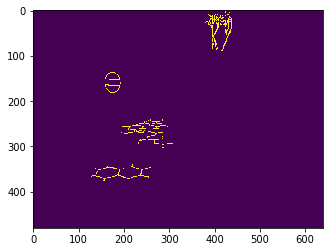

In [65]:
p_img = preprocess_image(frame_1)
p_img = removeSmallComponents(p_img,300)
plt.imshow(p_img)

In [79]:
contours = findContour(p_img)
for c in contours:
    print(c.shape)

(444, 1, 2)
(371, 1, 2)
(665, 1, 2)
(114, 1, 2)
(525, 1, 2)
(340, 1, 2)
